The nuts and bolts of Deep Graph Learning, with loading graph data and training a Vanilla GCN in PyTorch.

In [181]:
import torch
torch.__version__

'1.6.0+cu101'

In [182]:
# downloading the Cora Dataset
! wget -q https://github.com/tkipf/pygcn/raw/master/data/cora/cora.cites
! wget -q https://github.com/tkipf/pygcn/raw/master/data/cora/cora.content

In [183]:
# sparse matrices have a different encoding that saves space (doesn't store lots of zeros)
import numpy as np
import scipy.sparse as sp
import torch

In [184]:
# one-hot encode a list
def encode_onehot(labels):
  classes = set(labels)
  classes_dict = {c : np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
  labels_oh = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
  return labels_oh

In [185]:
encode_onehot(['apple', 'mango', 'banana', 'apple'])

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]], dtype=int32)

## The Dataset (Cora)

The Cora dataset consists of ML papers, classified into one of the following seven classes:
-	Case_Based
-	Genetic_Algorithms
-	Neural_Networks
-	Probabilistic_Methods
-	Reinforcement_Learning
-	Rule_Learning
-	Theory

The papers were selected in a way such that in the final corpus every paper cites or is cited by atleast one other paper. There are 2708 papers in the whole corpus. 

(This means the graph is a fully spanning graph with 2708 reachable nodes)

After stemming and removing stopwords we were left with a vocabulary of size 1433 unique words. 

`cora.content` contains descriptions of the papers in the following format:

		<paper_id> <word_attributes> <class_label>

The first entry in each line contains the unique string ID of the paper followed by binary values indicating whether each word in the vocabulary is present (indicated by 1) or absent (indicated by 0) in the paper. Finally, the last entry in the line contains the class label of the paper.

`cora.cites` contains the citation graph of the corpus. Each line describes a link in the following format:

		<ID of cited paper> <ID of citing paper>

Each line contains two paper IDs. The first entry is the ID of the paper being cited and the second ID stands for the paper which contains the citation. The direction of the link is from right to left. If a line is represented by "paper1 paper2" then the link is "paper2->paper1". 

In [186]:
# normalize a matrix row-wise
def normalize(mx):
  rowsum = np.array(mx.sum(1))
  r_inv  = np.power(rowsum, -1).flatten()
  r_inv[np.isinf(r_inv)] = 0.
  r_mat_inv = sp.diags(r_inv)
  mx = r_mat_inv.dot(mx)
  return mx

In [187]:
def dataloader(path='./', dataset='cora'):
  idxs, features, labels = load_nodes(path, dataset)
  idxs_map = {j : i for i, j in enumerate(idxs)}                      
  adj = load_adj(path, dataset, idxs_map, labels)
  features = normalize(features)
  adj = normalize(adj + sp.eye(adj.shape[0]))                         # add self loops
  idx_train, idx_val, idx_test = train_val_test_split(adj.shape[0])
  features = torch.FloatTensor(np.array(features.todense()))
  labels = torch.LongTensor(np.where(labels)[1])
  adj = sparse_mx_to_torch_sparse_tensor(adj)
  return adj, features, labels, idx_train, idx_val, idx_test

In [188]:
def load_nodes(path, dataset):
  nodes = np.genfromtxt(f'{path}{dataset}.content', dtype=np.dtype(str)) # index, features.., label
  features = sp.csr_matrix(nodes[:, 1:-1], dtype=np.float32) # one-hot dictionary words
  labels = encode_onehot(nodes[:, -1]) # the target to predict
  idxs = np.array(nodes[:, 0], dtype=np.int32) # the index of the papers (UID)
  return idxs, features, labels

In [189]:
def load_adj(path, dataset, idxs_map, labels):
  edges_unordered = np.genfromtxt(f'{path}{dataset}.cites', dtype=np.int32)
  edges = np.array(list(map(idxs_map.get, edges_unordered.flatten())), dtype=np.int32)
  edges = edges.reshape(edges_unordered.shape)
  edges_t = (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1]))
  adj = sp.coo_matrix(edges_t, shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)
  adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)              # undirected graph
  return adj

In [190]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
  sparse_mx = sparse_mx.tocoo().astype(np.float32)
  indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
  values = torch.from_numpy(sparse_mx.data)
  shape = torch.Size(sparse_mx.shape)
  return torch.sparse.FloatTensor(indices, values, shape)

In [191]:
def train_val_test_split(num_nodes, train=0.15, val=0.15):
  idx_train = np.random.choice(range(num_nodes), int(train * num_nodes), replace=False)
  idx_vt = list(set(range(num_nodes)) - set(idx_train))
  idx_val = np.random.choice(idx_vt, int(val * num_nodes), replace=False)
  idx_test = list(set(idx_vt) - set(idx_val))
  idx_train = torch.LongTensor(idx_train)
  idx_val = torch.LongTensor(idx_val)
  idx_test = torch.LongTensor(idx_test)
  return idx_train, idx_val, idx_test

In [192]:
def accuracy(output, labels):
  preds   = output.max(1)[1].type_as(labels)
  correct = preds.eq(labels).double()
  correct = correct.sum()
  return correct / len(labels)

In [193]:
adj, features, labels, idx_train, idx_val, idx_test = dataloader()

In [194]:
idx_train.shape, idx_val.shape, idx_test.shape

(torch.Size([406]), torch.Size([406]), torch.Size([1896]))

In [195]:
features.shape

torch.Size([2708, 1433])

In [196]:
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [197]:
class GraphConv(nn.Module):

  def __init__(self, in_features, out_features):
    super(GraphConv, self).__init__()
    self.in_features  = in_features
    self.out_features = out_features
    self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
    self.bias = nn.Parameter(torch.Tensor(out_features))
    self.reset_parameters()
    
  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input, adj):
    support = torch.mm(input, self.weight)
    output = torch.spmm(adj, support)     # permutation inv sum of all neighbor features
    return output + self.bias

    def __repr__(self):
      return self.__class__.__name__ +' ('+str(self.in_features)+' -> '+str(self.out_features)+')'

In [216]:
class VanillaGCN(nn.Module):

  def __init__(self, nfeat, nhid, nclass, dropout):
    super(VanillaGCN, self).__init__()
    self.gc1 = GraphConv(nfeat, nhid)
    self.gc3 = GraphConv(nhid, nhid)
    self.gc2 = GraphConv(nhid, nclass)
    self.dropout = dropout

  def forward(self, x, adj):
    x = F.relu(self.gc1(x, adj))
    x = F.dropout(x, self.dropout, training=self.training)
    x = F.relu(self.gc3(x, adj))
    x = self.gc2(x, adj)
    return F.log_softmax(x, dim=1)

In [217]:
CUDA = torch.cuda.is_available()
SEED = 42
torch.manual_seed(SEED)
if CUDA: torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [226]:
lr = 0.01
# epochs = 200
epochs = 200
wd = 5e-4
hidden = 16
dropout = 0.5
fastmode = False

In [227]:
model = VanillaGCN(nfeat=features.shape[1], nhid=hidden, nclass=labels.max().item() + 1, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [228]:
if CUDA:
  model.cuda()
  features = features.cuda()
  adj = adj.cuda()
  labels = labels.cuda()
  idx_train = idx_train.cuda()
  idx_val = idx_val.cuda()
  idx_test = idx_test.cuda()

In [229]:
def train(epoch):
  t = time.time()
  model.train()
  optimizer.zero_grad()
  output = model(features, adj)
  loss_train = F.nll_loss(output[idx_train], labels[idx_train])
  acc_train = accuracy(output[idx_train], labels[idx_train])
  loss_train.backward()
  optimizer.step()
  if not fastmode:
      model.eval()
      output = model(features, adj)
  loss_val = F.nll_loss(output[idx_val], labels[idx_val])
  acc_val = accuracy(output[idx_val], labels[idx_val])
  if epoch % 10 == 0:
    print('Epoch: {:04d}'.format(epoch+1),
        'loss_train: {:.4f}'.format(loss_train.item()),
        'loss_val: {:.4f}'.format(loss_val.item()),
        'acc_val: {:.4f}'.format(acc_val.item()))
  return loss_train.item(), loss_val.item()

In [230]:
def test():
  model.eval()
  output = model(features, adj)
  loss_test = F.nll_loss(output[idx_test], labels[idx_test])
  acc_test = accuracy(output[idx_test], labels[idx_test])
  print("Test set results:",
        "loss= {:.4f}".format(loss_test.item()),
        "accuracy= {:.4f}".format(acc_test.item()))

In [231]:
import time
t_total = time.time()
train_losses, val_losses = [], []
for epoch in range(epochs):
  loss_train, loss_val = train(epoch)
  train_losses.append(loss_train)
  val_losses.append(loss_val)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0001 loss_train: 1.9926 loss_val: 1.9627 acc_val: 0.0764
Epoch: 0011 loss_train: 1.8385 loss_val: 1.8374 acc_val: 0.2956
Epoch: 0021 loss_train: 1.7642 loss_val: 1.7984 acc_val: 0.2956
Epoch: 0031 loss_train: 1.6331 loss_val: 1.6725 acc_val: 0.3547
Epoch: 0041 loss_train: 1.4116 loss_val: 1.4765 acc_val: 0.4163
Epoch: 0051 loss_train: 1.2210 loss_val: 1.3164 acc_val: 0.5172
Epoch: 0061 loss_train: 1.0190 loss_val: 1.1598 acc_val: 0.6453
Epoch: 0071 loss_train: 0.8321 loss_val: 0.9927 acc_val: 0.7143
Epoch: 0081 loss_train: 0.6560 loss_val: 0.8517 acc_val: 0.7635
Epoch: 0091 loss_train: 0.4930 loss_val: 0.7492 acc_val: 0.8030
Epoch: 0101 loss_train: 0.4051 loss_val: 0.6978 acc_val: 0.8325
Epoch: 0111 loss_train: 0.3406 loss_val: 0.6770 acc_val: 0.8300
Epoch: 0121 loss_train: 0.3333 loss_val: 0.6536 acc_val: 0.8350
Epoch: 0131 loss_train: 0.2903 loss_val: 0.6298 acc_val: 0.8276
Epoch: 0141 loss_train: 0.2639 loss_val: 0.6094 acc_val: 0.8325
Epoch: 0151 loss_train: 0.2168 loss_val:

In [232]:
test()

Test set results: loss= 0.6001 accuracy= 0.8318


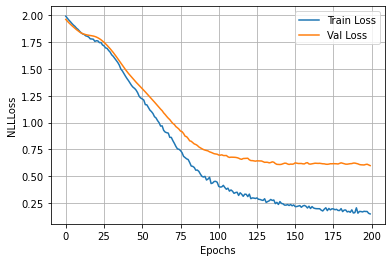

In [233]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('NLLLoss')
plt.legend()

Sometime soon, we'll have week-13 of [this](https://www.youtube.com/watch?v=f01J0Dri-6k&list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq&index=24&t=0s) and that should be really good!

Also, ICML 2020 had a workshop on [GRL+](https://slideslive.com/icml-2020/graph-representation-learning-and-beyond-grl), should definitely watch relevant presentations

### Experiment Journal:

1. Default hyperparams, default splits (140, 300, 1000) => 0.81
2. Default hyperparams, splits (200, 300, 1000) => 0.83
3. Default hyperparamas, random splits (0.1, 0.2, 0.7) => 0.8044
4. Default hyperparamas, random splits (0.5, 0.2, 0.3) => 0.8918
5. Default hyperparamas, random splits (0.5, 0.2, 0.3) without bias => 0.8512
5. 100 epochs, 1 hidden layer, random splits (0.15, 0.15, 0.7) without bias => 0.7342
5. 100 epochs, 2 hidden layer, random splits (0.15, 0.15, 0.7) without bias => 0.7453